# NBA Analytics: Machine Learning to Predict Win Shares

In [168]:
# All the packages we will be using

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from operator import itemgetter
plt.style.use('fivethirtyeight')

In [169]:
# Import 2017 & 2018 Basic NBA stats datasets (Points, Assists, Rebounds, FG%)

basic_2017 = pd.read_csv('2017_season.csv')
basic_2018 = pd.read_csv('2018_season.csv')

basic_2017 = basic_2017.loc[:, 'Player': 'PS/G']
basic_2017 = basic_2017[basic_2017['G'] >= 15]
basic_2017 = basic_2017[basic_2017['MP'] >= 15]

basic_2018 = basic_2018.loc[:, 'Player': 'PS/G']
basic_2018 = basic_2018[basic_2018['G'] >= 15]
basic_2018 = basic_2018[basic_2018['MP'] >= 15]

In [170]:
# Import 2017 & 2018 Advanced NBA stats datasets (VORP, TS%, eFG%, USG%, WS)

advanced_2017 = pd.read_csv('Seasons_Stats.csv')
advanced_2018 = pd.read_csv('2017-18_AdvancedStats_Salary.csv', sep=',',encoding='latin-1')


advanced_2017 = advanced_2017[advanced_2017['Year'] == 2017]
advanced_2017 = advanced_2017.drop_duplicates('Player', keep = 'first')

advanced_2017['PPG'] = round(advanced_2017['PTS'] / advanced_2017['G'], 2)
advanced_2017['MPG'] = round(advanced_2017['MP'] / advanced_2017['G'], 2)

advanced_2017 = advanced_2017[advanced_2017['MPG'] >= 15]
season_2017_advanced = advanced_2017[advanced_2017['G'] >= 15]

advanced_2017 = advanced_2017[['Player','PER','TS%','USG%','OWS','WS','WS/48','OBPM','BPM','VORP','DWS','DBPM','STL%','PPG']]

advanced_2018 = advanced_2018.drop_duplicates('Player', keep = 'first')
advanced_2018['MPG'] = round(advanced_2018['MP'] / advanced_2018['G'], 2)

advanced_2018 = advanced_2018[advanced_2018['MPG'] > 15]
advanced_2018 = advanced_2018[advanced_2018['G'] > 15]
advanced_2018 = advanced_2018[['Player','PER','TS%','USG%','OWS','WS','WS/48','OBPM','BPM','VORP','DWS','DBPM','STL%']]

In [172]:
# Combine Basic NBA stats and Advanced NBA stats data into 2 datasets (2017 & 2018 season)

stats_2017 = basic_2017.merge(advanced_2017, on = 'Player', how = 'inner')
stats_2018 = basic_2018.merge(advanced_2018, on = 'Player', how = 'inner')

ws_2018 = stats_2018[['Player', 'WS']]

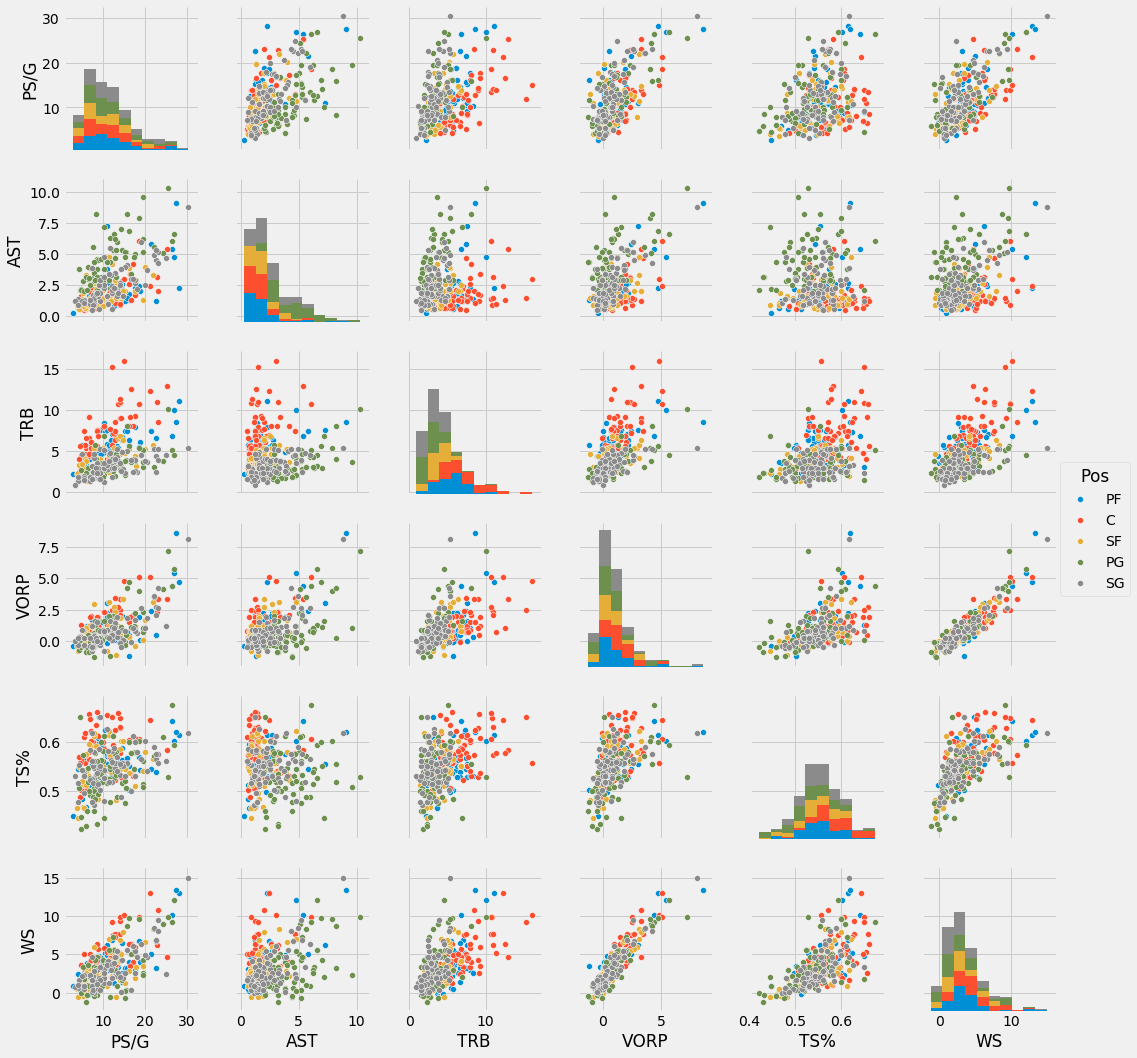

In [173]:
stats_2018['Pos'] = stats_2018['Pos'].replace('PG-SG', 'PG')
s_2018 = stats_2018[['Player','Pos','PS/G','AST','TRB','VORP','TS%','WS']]

sb.pairplot(s_2018.dropna(), hue='Pos');

In [174]:
# Create the train test datasets

train, test = train_test_split(stats_2017, test_size=0.25, random_state=99)

x_train = train[['PS/G','AST','TRB','VORP','TS%','BPM']]
y_train = train[['WS']]

x_test = test[['PS/G','AST','TRB','VORP','TS%','BPM']]
y_test = test[['WS']]

In [175]:
# Create the Linear Regression model

linReg = linear_model.LinearRegression()
linReg.fit(x_train, y_train)

linReg.predict(x_test)

y_lin_pred = linReg.predict(x_test)

print('Mean squared error: %.3f' % mean_squared_error(y_test, y_lin_pred))
print('Variance score: %.3f' % r2_score(y_test, y_lin_pred))
print('Score: %.3f' % linReg.score(x_train, y_train))

Mean squared error: 1.140
Variance score: 0.886
Score: 0.893


In [176]:
svr = SVR(kernel='rbf', gamma=1e-3, C=150, epsilon=0.3)
svr.fit(x_train, y_train.values.ravel())

y_svr_pred = svr.predict(x_test)


print("Mean squared error: %.3f" % mean_squared_error(y_test, y_svr_pred))
print('Variance score: %.3f' % r2_score(y_test, y_svr_pred))
print('Score: %.3f' % svr.score(x_train, y_train))

Mean squared error: 1.227
Variance score: 0.877
Score: 0.927


In [177]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 7, weights = 'uniform')
knn.fit(x_train, y_train)

y_knn = knn.predict(x_test)

print("Mean Squared Error: %.3f" % mean_squared_error(y_test, y_knn))
print('Variance Score: %.3f' % r2_score(y_test, y_knn))
print('Score: %.3f' % knn.score(x_train, y_train))

Mean Squared Error: 1.851
Variance Score: 0.814
Score: 0.865


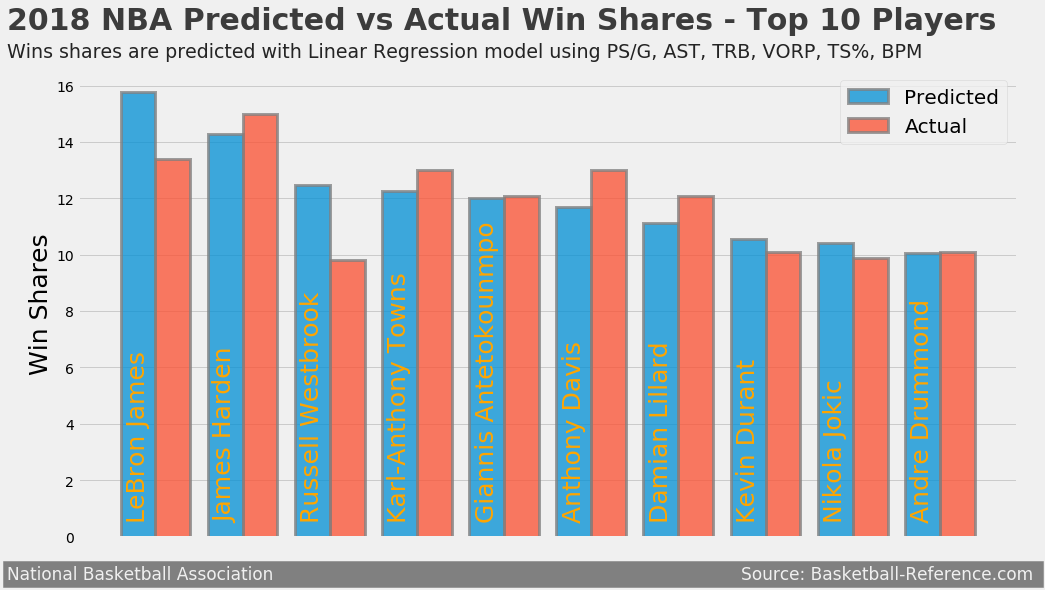

In [224]:
# Predict Win Shares using Linear Regression Model

lin_new = stats_2018[['PS/G','AST','TRB','VORP','TS%','BPM']]

lin_pred_2018 = linReg.predict(lin_new)

lin_names = stats_2018.iloc[:, 0]
a = []
for i, j in zip(lin_pred_2018, lin_names):
    a.append({'WS_pred':i,'Player':j})

lin_wins = pd.DataFrame(a)
lin_wins['WS_pred'] = round(lin_wins['WS_pred'].astype(float),2)

lin_wins = lin_wins.sort_values([('WS_pred')], ascending = False).reset_index(drop=True).head(10)
lin_wins = lin_wins.merge(ws_2018, on = 'Player', how = 'inner')


pos = np.arange(len(lin_wins['WS_pred']))

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (15,8))
plt.bar(pos, lin_wins['WS_pred'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3, label = 'Predicted')
plt.bar(pos + .4, lin_wins['WS'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3, label = 'Actual')
for i in pos:
    plt.text(pos[i], 0.5, s = lin_wins['Player'][i],ha='center', va='bottom', rotation = 'vertical',color = 'orange', size = 25)
plt.text(x = -1.5, y = 18, s = '2018 NBA Predicted vs Actual Win Shares - Top 10 Players',fontsize = 30, weight = 'bold', alpha = .75)
plt.text(x = -1.5, y = 17, s = 'Wins shares are predicted with Linear Regression model using PS/G, AST, TRB, VORP, TS%, BPM',fontsize = 19, alpha = .85)
plt.text(x = -1.5, y = -1.5, s = 'National Basketball Association                                                                                       Source: Basketball-Reference.com ', fontsize = 17,color = '#f0f0f0', backgroundcolor = 'grey')
plt.xticks([],[])
plt.legend(prop={'size': 20})
ax.set_ylabel('Win Shares', size = 25);

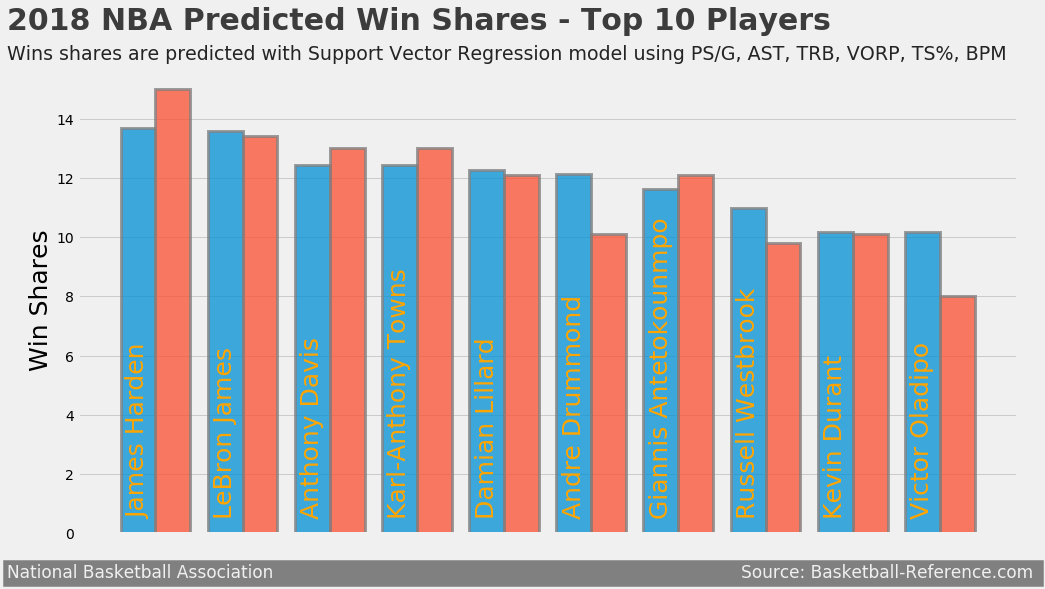

In [225]:
# Predict Win Shares using Support Vector Regression Model

svr_new = stats_2018[['PS/G','AST','TRB','VORP','TS%','BPM']]

svr_pred_2018 = svr.predict(svr_new)

svr_names = stats_2018.iloc[:, 0]

b = []
for i, j in zip(svr_pred_2018, svr_names):
    b.append({'WS_pred':i,'Player':j})


svr_wins = pd.DataFrame(b)
svr_wins['WS_pred'] = round(svr_wins['WS_pred'].astype(float),2)

svr_wins = svr_wins.sort_values([('WS_pred')], ascending = False).reset_index(drop=True).head(10)
svr_wins = svr_wins.merge(ws_2018, on = 'Player', how = 'inner')

pos = np.arange(len(svr_wins['WS_pred']))

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (15,8))
plt.bar(pos, svr_wins['WS_pred'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3)
plt.bar(pos + 0.4, svr_wins['WS'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3)
for i in pos:
    plt.text(pos[i], 0.5, s = svr_wins['Player'][i],ha='center', va='bottom', rotation = 'vertical',color = 'orange', size = 25)
plt.text(x = -1.5, y = 17, s = '2018 NBA Predicted Win Shares - Top 10 Players',fontsize = 30, weight = 'bold', alpha = .75)
plt.text(x = -1.5, y = 16, s = 'Wins shares are predicted with Support Vector Regression model using PS/G, AST, TRB, VORP, TS%, BPM',fontsize = 19, alpha = .85)
plt.text(x = -1.5, y = -1.5, s = 'National Basketball Association                                                                                       Source: Basketball-Reference.com ', fontsize = 17,color = '#f0f0f0', backgroundcolor = 'grey')
plt.xticks([],[])
ax.set_ylabel('Win Shares', size = 25);

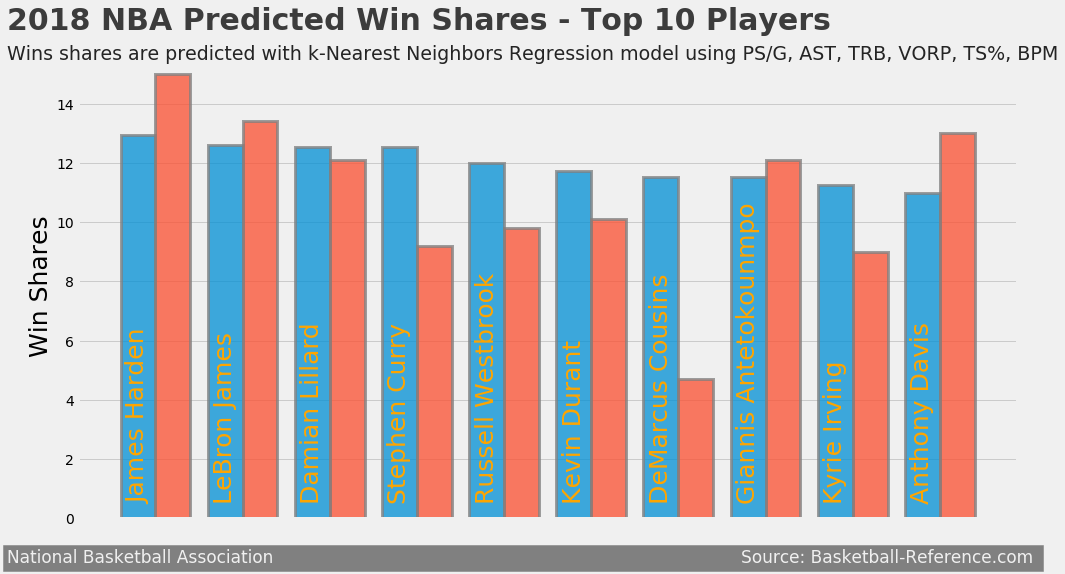

In [226]:
# Predict Win Shares using Support Vector Regression Model

knn_new = stats_2018[['PS/G','AST','TRB','VORP','TS%','BPM']]

knn_pred_2018 = knn.predict(svr_new)

knn_names = stats_2018.iloc[:, 0]

c = []
for i, j in zip(knn_pred_2018, knn_names):
    c.append({'WS_pred':i,'Player':j})


knn_wins = pd.DataFrame(c)
knn_wins['WS_pred'] = round(knn_wins['WS_pred'].astype(float),2)

knn_wins = knn_wins.sort_values([('WS_pred')], ascending = False).reset_index(drop=True).head(10)
knn_wins = knn_wins.merge(ws_2018, on = 'Player', how = 'inner')


pos = np.arange(len(knn_wins['WS_pred']))

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (15,8))
plt.bar(pos, knn_wins['WS_pred'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3)
plt.bar(pos + 0.4, knn_wins['WS'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3)
for i in pos:
    plt.text(pos[i], 0.5, s = knn_wins['Player'][i],ha='center', va='bottom', rotation = 'vertical',color = 'orange', size = 25)
plt.text(x = -1.5, y = 16.5, s = '2018 NBA Predicted Win Shares - Top 10 Players',fontsize = 30, weight = 'bold', alpha = .75)
plt.text(x = -1.5, y = 15.5, s = 'Wins shares are predicted with k-Nearest Neighbors Regression model using PS/G, AST, TRB, VORP, TS%, BPM',fontsize = 19, alpha = .85)
plt.text(x = -1.5, y = -1.5, s = 'National Basketball Association                                                                                       Source: Basketball-Reference.com ', fontsize = 17,color = '#f0f0f0', backgroundcolor = 'grey')
plt.xticks([],[])
ax.set_ylabel('Win Shares', size = 25);